<a href="https://colab.research.google.com/github/williamgomalley/ML_Finance_Codes/blob/master/Lasso_for_SmallerDataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
import csv
import pandas as pd
import numpy as np
import re
import math
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.regularizers import l1,l2
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import statsmodels.api as sm
import datetime as dt
from dateutil.relativedelta import *
import timeit
from keras.callbacks import EarlyStopping
import pickle

### Define a deep neural network (with $L-1$ hidden layers) model in Keras

We define functions for the creation, training, and optional parameter tuning of the model. 

In [107]:
def NN(n_inputs, n_units=50, dropout=0.1, l1_reg=0.001, activation='relu', L=2):
    # L>0 is the number of hidden layers
    
    model = Sequential()
    model.add(Dense(units=n_units, input_dim=n_inputs, kernel_regularizer=l1(l1_reg), kernel_initializer='normal', activation=activation))
    model.add(Dropout(dropout))
    for i in range (0, L-1):
        model.add(Dense(units=n_units, kernel_regularizer=l1(l1_reg), kernel_initializer='normal', activation=activation))
        model.add(Dropout(dropout))
    model.add(Dense(1, kernel_initializer='normal')) 
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model

In [108]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)

This function selects the best-performing combination of parameter values in `param_grid` cross-validated over `cv` folds

In [109]:
def parameter_tuning(X, y, cv=3, n_epochs=100, n_batch=10, seed=7):
    param_grid = dict(n_inputs=[X.shape[1]], n_units=[10, 20, 50], 
                      l1_reg = [0, 0.0001, 0.001], activation=['relu','tanh']) 
    estimator = KerasRegressor(build_fn=NN, epochs=n_epochs, batch_size=n_batch, verbose=0)   
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, 
                        cv=cv)
    grid_result = grid.fit(X, y, callbacks=[es])
  
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid_result.best_params_

In [110]:
def training(X, Y, training_dates, L, tune=False):
 
    n_epochs = 100 # maximum number of epochs (to be used with early stopping)
    n_batch = 10 # mini-batch size
    drop_out = 0.0 # level of dropout (set between 0 and 1)
    n_units = 10   
    l1_reg = 0.001 # L_1 regularization parameter
    activation = 'tanh'

    # Create the dictionaries to hold the results
    models = {}
    models['linear'] = []
    models['NN'] = []

    xs = {}
    xs['train'] = []
    xs['test'] = []
    
    ys = {}
    ys['train'] = []
    ys['test'] = []
    
    betas = {}
    betas['NN'] = []
    betas['linear'] = []

    i = 0
    for date in training_dates:
        start_time = timeit.default_timer()  
        print(i, date)
        
        # The following month's date (for the test set)
        date_next = pd.Timestamp(np.datetime64(date)).to_pydatetime() + relativedelta(months=+1)
        date_next = date_next.strftime('%Y-%m-%d')

        # Get the indices of the training and testing points
        train_index = X[X['date'] == date].index
        test_index  = X[X['date'] == date_next].index
        
        # Skip the model if either the train or test sets would be empty
        if len(train_index) == 0 or len(test_index) == 0:
            continue

        # Make the train and test sets
        x_train = X.loc[train_index]
        x_train = x_train.drop("date", axis=1)
        y_train = Y.loc[train_index]
        y_train= y_train.drop("date", axis=1)
        x_test = X.loc[test_index]
        x_test = x_test.drop("date", axis=1)
        y_test = Y.loc[test_index]
        y_test = y_test.drop("date", axis=1)
        
        n_inputs = x_train.shape[1]
        if n_inputs == 0:
            continue
       
        if tune: # Only perform parameter tuning once
            print("Parameter tuning with X-validation...")
            best_params = parameter_tuning(x_train, y_train, 3)
            n_units = best_params['n_units']
            l1_reg = best_params['l1_reg']
            activation = best_params['activation']
            tune = False
        
        # Create and fit the NN for the current training date
        model = NN(n_units=n_units, n_inputs=n_inputs, dropout=drop_out, l1_reg=l1_reg, activation=activation, L=L)
        model.fit(x_train.values, y_train.values, epochs=n_epochs, batch_size=n_batch, verbose=0, callbacks=[es])   
        beta = sensitivities(model, x_train.values, L, activation)   
        
        # Save the results
        models['NN'].append(model)
        betas['NN'].append(beta)
        
        # Fit the OLS regression model for the current date
        x = sm.add_constant(x_train)
        interaction = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
        x = interaction.fit_transform(x_train)
        model=linear_model.LassoCV(n_alphas=7, fit_intercept=True, normalize=False).fit(x,y_train)
        betas['linear'].append(model.coef_[:7])   # with elements from index first to last – 1
        #beta_interacts['linear'].append(model.coef_[49:])
        models['linear'].append(model)
        # Save the corresponding inputs and outputs for each model 
        xs['train'].append(x_train)
        xs['test'].append(x_test)
        ys['train'].append(y_train)
        ys['test'].append(y_test)

        elapsed = timeit.default_timer() - start_time
        print("Elapsed time: " + str(elapsed) + " (s)")
        i += 1
        
    return models, betas, xs, ys, interaction

This function allows us to compute the feature sensitivities in the deep network. It assumes that the activation function is either $tanh$ or $relu$.

In [111]:
def sensitivities(lm, X, L, activation='tanh'):
    W = lm.get_weights()
    M = np.shape(X)[0]
    p = np.shape(X)[1]
    beta = np.zeros((M, p+1))
    B_0 = W[1]
    for i in range (0, L):
        if activation == 'tanh':  
            B_0 = (np.dot(np.transpose(W[2*(i+1)]), np.tanh(B_0)) + W[2*(i+1)+1])
        elif activation == 'relu':
            B_0 = (np.dot(np.transpose(W[2*(i+1)]), np.maximum(B_0, 0)) + W[2*(i+1)+1])
    beta[:, 0] = B_0 # intercept \beta_0 = F_{W,b}(0)
    for i in range(M):
        I1 = np.dot(np.transpose(W[0]), np.transpose(X[i,])) + W[1]
        if activation == 'tanh':
            Z = np.tanh(I1)  
            D = np.diag(1 - Z**2)
        elif activation == 'relu':
            Z = np.maximum(I1, 0)
            D = np.diag(np.sign(Z)) 
        
        for j in range(p):
            J = np.dot(D, W[0][j])       
            for a in range (1, L):
                I = np.dot(np.transpose(W[2*a]), Z) + W[2*a+1] 
                if activation == 'tanh':  
                    Z = np.tanh(I)
                    D = np.diag(1 - Z**2)
                elif activation == 'relu':    
                    Z = np.maximum(I,0)
                    D = np.diag(np.sign(Z)) 
                J = np.dot(np.dot(D, np.transpose(W[2*a])), J)
            beta[i, j+1]=np.dot(np.transpose(W[2*L]), J)
    return beta

Load the data

In [112]:
X = pd.read_csv('X_small.csv') # Factor exposures
Y = pd.read_csv('Y_small.csv') # Asset returns

## Training of models 
A new cross-sectional neural network model is fitted in each period. To evaluate the performance of strategies, we need to train a model for each time step over a historical period. 

In [113]:
training_periods = 100
L = 2 # Number of hidden and output layers
dates = np.unique(X['date'])[0:training_periods] 
models, betas, xs, ys,interaction = training(X,Y,dates,L)

0 2008-02-01
Epoch 00014: early stopping
Elapsed time: 1.2225780480002868 (s)
1 2008-03-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 00014: early stopping
Elapsed time: 0.955032519002998 (s)
2 2008-04-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002882528849499355, tolerance: 8.990176228143621e-05
  tol, rng, random, positive)


Epoch 00012: early stopping
Elapsed time: 0.9484038440023141 (s)
3 2008-05-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014514911945169295, tolerance: 9.843777477758697e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2927585652699208, tolerance: 0.00011625925211559743
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wa

Epoch 00011: early stopping
Elapsed time: 0.894753751999815 (s)
4 2008-06-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015337358900842535, tolerance: 0.00012050901344605037
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011363137396965928, tolerance: 0.00011435289343492255
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might 

Epoch 00012: early stopping
Elapsed time: 0.9119252019991109 (s)
5 2008-07-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000431586417097618, tolerance: 8.962246493863393e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013457950131752217, tolerance: 9.70640996188785e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wa

Epoch 00012: early stopping
Elapsed time: 0.9024865460014553 (s)
6 2008-08-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005811027754971665, tolerance: 0.00010211401466821065
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10058008842699284, tolerance: 0.00010211401466821065
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might 

Epoch 00013: early stopping
Elapsed time: 0.9184620980013278 (s)
7 2008-09-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024436634083113695, tolerance: 0.0001941272127783741
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018654411551333183, tolerance: 0.0001941272127783741
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might

Epoch 00014: early stopping
Elapsed time: 1.0295643839999684 (s)
8 2008-10-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008053851264236966, tolerance: 9.825527655312441e-05
  tol, rng, random, positive)


Epoch 00061: early stopping
Elapsed time: 1.8487983399973018 (s)
9 2008-11-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06604773735355962, tolerance: 0.00018448654045471262
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05039151257385488, tolerance: 0.00017168091288562265
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wa

Epoch 00024: early stopping
Elapsed time: 1.1152566720011237 (s)
10 2008-12-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4585880147594906, tolerance: 0.0002543012214225947
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031785901767777958, tolerance: 0.0003327841005473436
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wan

Epoch 00027: early stopping
Elapsed time: 1.1821317210014968 (s)
11 2009-01-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.313336658723708, tolerance: 0.00030676463130813544
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023010532568437103, tolerance: 0.00030814429070464015
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wan

Epoch 00058: early stopping
Elapsed time: 1.7689755280007375 (s)
12 2009-02-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005649771455504826, tolerance: 0.0004613431802296754
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02677857721983301, tolerance: 0.0004613431802296754
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wa

Epoch 00011: early stopping
Elapsed time: 0.861606042002677 (s)
13 2009-03-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036721226176978927, tolerance: 0.00023174322537781094
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.047605347573327794, tolerance: 0.00018437919562499513
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might

Epoch 00030: early stopping
Elapsed time: 1.2383995790005429 (s)
14 2009-04-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002649594703443503, tolerance: 0.0002661022417516909
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002492796119807128, tolerance: 0.0002982742404934191
  tol, rng, random, positive)


Epoch 00029: early stopping
Elapsed time: 1.2277656070000376 (s)
15 2009-05-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 00012: early stopping
Elapsed time: 0.9093433390007704 (s)
16 2009-06-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0939962622045667, tolerance: 0.0005342064739548859
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042090920054338454, tolerance: 0.0003880618744846133
  tol, rng, random, positive)


Epoch 00013: early stopping
Elapsed time: 0.9208023259998299 (s)
17 2009-07-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004765721336261741, tolerance: 0.0001255675046746135
  tol, rng, random, positive)


Epoch 00013: early stopping
Elapsed time: 0.90543002800041 (s)
18 2009-08-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011083813513923513, tolerance: 7.243397063091832e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001952236492079873, tolerance: 8.526685596795031e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might

Epoch 00015: early stopping
Elapsed time: 0.9388205559989728 (s)
19 2009-09-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 00013: early stopping
Elapsed time: 0.8898641870000574 (s)
20 2009-10-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23048372748586704, tolerance: 8.365874944070216e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.27158893791002214, tolerance: 8.929449912085356e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want

Epoch 00015: early stopping
Elapsed time: 0.9394078669974988 (s)
21 2009-11-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017099418743837802, tolerance: 8.096932126681213e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17901901861358302, tolerance: 8.096932126681213e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might w

Epoch 00015: early stopping
Elapsed time: 0.9460649429965997 (s)
22 2009-12-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042365392154131154, tolerance: 7.816827309141339e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002417995180937549, tolerance: 6.356689353688998e-05
  tol, rng, random, positive)


Epoch 00010: early stopping
Elapsed time: 0.834466649001115 (s)
23 2010-01-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006784281142807047, tolerance: 7.55131321092167e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004338285181436419, tolerance: 6.797442064273176e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wan

Epoch 00013: early stopping
Elapsed time: 0.9018709960000706 (s)
24 2010-02-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007325465594936187, tolerance: 9.732456559749285e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021207036698697834, tolerance: 9.680602700294024e-05
  tol, rng, random, positive)


Epoch 00014: early stopping
Elapsed time: 0.9636903409991646 (s)
25 2010-03-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.313515505658064e-05, tolerance: 5.480057573928865e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002403442779564391, tolerance: 5.326682162207883e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might 

Epoch 00015: early stopping
Elapsed time: 0.9315608309989329 (s)
26 2010-04-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027009502282474007, tolerance: 4.492681068656391e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001346135783377722, tolerance: 6.259357730379944e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might 

Epoch 00012: early stopping
Elapsed time: 0.8734650389997114 (s)
27 2010-05-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.219499801385589e-05, tolerance: 3.744163759597298e-05
  tol, rng, random, positive)


Epoch 00011: early stopping
Elapsed time: 0.8422169719997328 (s)
28 2010-06-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000156159034328196, tolerance: 9.09638296011171e-05
  tol, rng, random, positive)


Epoch 00012: early stopping
Elapsed time: 0.8815760190009314 (s)
29 2010-07-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010373365581684002, tolerance: 8.73006603013134e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005339473233514358, tolerance: 8.403955721788869e-05
  tol, rng, random, positive)


Epoch 00014: early stopping
Elapsed time: 0.8971417270004167 (s)
30 2010-08-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.8680361436358464e-05, tolerance: 5.82481113026361e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09611068829193864, tolerance: 5.82481113026361e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wan

Epoch 00036: early stopping
Elapsed time: 1.3298990369985404 (s)
31 2010-09-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00036350785523242557, tolerance: 0.00010642138423954235
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030917872308156014, tolerance: 0.00010706838157691857
  tol, rng, random, positive)


Epoch 00019: early stopping
Elapsed time: 1.0050248869993084 (s)
32 2010-10-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025714660052628124, tolerance: 8.390396656464709e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0636691357390132, tolerance: 8.390396656464709e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wa

Epoch 00014: early stopping
Elapsed time: 0.917661407002015 (s)
33 2010-11-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010483220319888464, tolerance: 6.365978929016871e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001301822422821508, tolerance: 5.548698357500886e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might w

Epoch 00011: early stopping
Elapsed time: 0.8567722410007264 (s)
34 2010-12-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00037071561879192805, tolerance: 5.4535120660117875e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004961363586335477, tolerance: 5.2384777721642795e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You mig

Epoch 00013: early stopping
Elapsed time: 0.8885260820024996 (s)
35 2011-01-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024931476347556103, tolerance: 6.062257403465724e-05
  tol, rng, random, positive)


Epoch 00012: early stopping
Elapsed time: 0.8708135489978304 (s)
36 2011-02-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005574687512553966, tolerance: 4.950678424977106e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.052840516917749825, tolerance: 5.064659521388817e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might w

Epoch 00016: early stopping
Elapsed time: 0.9448591890031821 (s)
37 2011-03-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015329783999299407, tolerance: 5.9362535063228416e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034324820617616325, tolerance: 9.487426480611154e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might 

Epoch 00011: early stopping
Elapsed time: 0.8515895040000032 (s)
38 2011-04-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012396988135373599, tolerance: 5.04707007872826e-05
  tol, rng, random, positive)


Epoch 00015: early stopping
Elapsed time: 2.1784815520004486 (s)
39 2011-05-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010141851429724125, tolerance: 5.060434129520948e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026873323875159505, tolerance: 5.060434129520948e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might

Epoch 00017: early stopping
Elapsed time: 1.0187759039981756 (s)
40 2011-06-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012411816702317946, tolerance: 5.066364419246958e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004750875759706286, tolerance: 5.697809443868658e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might w

Epoch 00011: early stopping
Elapsed time: 0.8643452510004863 (s)
41 2011-07-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.644110592810229e-05, tolerance: 4.519855246568003e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032181256909667444, tolerance: 4.519855246568003e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might 

Epoch 00015: early stopping
Elapsed time: 0.937118272002408 (s)
42 2011-08-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.4768441747010677e-05, tolerance: 3.694318997525097e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.041112109261615265, tolerance: 3.694318997525097e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might 

Epoch 00014: early stopping
Elapsed time: 0.9109884270001203 (s)
43 2011-09-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12053230509079943, tolerance: 7.823052440219405e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011526142805179385, tolerance: 6.978529553176116e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might w

Epoch 00011: early stopping
Elapsed time: 0.8191622949998418 (s)
44 2011-10-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013821715818507219, tolerance: 8.473898554226322e-05
  tol, rng, random, positive)


Epoch 00017: early stopping
Elapsed time: 0.9438603620001231 (s)
45 2011-11-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 00011: early stopping
Elapsed time: 0.842047341997386 (s)
46 2011-12-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 00015: early stopping
Elapsed time: 0.9341745839992655 (s)
47 2012-01-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012158050979282908, tolerance: 5.247918109185746e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0378882665098918, tolerance: 5.247918109185746e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wa

Epoch 00013: early stopping
Elapsed time: 0.8654372089986282 (s)
48 2012-02-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 00015: early stopping
Elapsed time: 0.9064432579980348 (s)
49 2012-03-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013009061217656992, tolerance: 0.00017054483087965592
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13103247858065026, tolerance: 0.00017054483087965592
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might 

Epoch 00019: early stopping
Elapsed time: 0.9822021710024273 (s)
50 2012-04-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 00014: early stopping
Elapsed time: 0.9117597590011428 (s)
51 2012-05-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03100178646748225, tolerance: 4.0072621152821614e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019669603933728075, tolerance: 3.669532945683875e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wa

Epoch 00011: early stopping
Elapsed time: 0.859661626000161 (s)
52 2012-06-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009785391435160107, tolerance: 5.8707858469968336e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08527906313215314, tolerance: 5.8707858469968336e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might w

Epoch 00012: early stopping
Elapsed time: 0.8729834459991253 (s)
53 2012-07-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07056099873750182, tolerance: 7.344858211416283e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02658642163779046, tolerance: 7.344858211416283e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want

Epoch 00011: early stopping
Elapsed time: 0.8982782989987754 (s)
54 2012-08-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024818038769546247, tolerance: 7.451256679530644e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13069692589211684, tolerance: 7.451256679530644e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wa

Epoch 00016: early stopping
Elapsed time: 1.0134320119977929 (s)
55 2012-09-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003849632845110973, tolerance: 7.192726294069876e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09577344612382888, tolerance: 7.192726294069876e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wa

Epoch 00017: early stopping
Elapsed time: 1.039554371000122 (s)
56 2012-10-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003490553380436745, tolerance: 5.0443865492263745e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002895096385409912, tolerance: 5.0417722780727585e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might 

Epoch 00011: early stopping
Elapsed time: 0.9101254179986427 (s)
57 2012-11-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007141024545782582, tolerance: 4.111046003384559e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03896034442506466, tolerance: 4.111046003384559e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wa

Epoch 00020: early stopping
Elapsed time: 1.1106829079981253 (s)
58 2012-12-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020778149054412332, tolerance: 7.491021330545303e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00972083104460053, tolerance: 7.491021330545303e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might w

Epoch 00020: early stopping
Elapsed time: 1.1255262459999358 (s)
59 2013-01-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017154799398374498, tolerance: 5.592884365678717e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013430926151272171, tolerance: 5.592884365678717e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might 

Epoch 00017: early stopping
Elapsed time: 1.0010536960035097 (s)
60 2013-02-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.171179745395739, tolerance: 5.261125512540096e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019911410656564543, tolerance: 4.798887756358009e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wan

Epoch 00013: early stopping
Elapsed time: 0.9209045700008573 (s)
61 2013-03-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039285523100240916, tolerance: 0.00012776269798314775
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009845089139903784, tolerance: 0.00013421531781803266
  tol, rng, random, positive)


Epoch 00011: early stopping
Elapsed time: 0.9000644510015263 (s)
62 2013-04-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14960769132832807, tolerance: 3.8478614384053926e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14558836828638622, tolerance: 3.8478614384053926e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wa

Epoch 00014: early stopping
Elapsed time: 0.9718760600007954 (s)
63 2013-05-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00114010033355183, tolerance: 4.3879430298992826e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003415353295628809, tolerance: 4.1059464380333416e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might 

Epoch 00013: early stopping
Elapsed time: 0.9330196539995086 (s)
64 2013-06-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012890291555076594, tolerance: 7.823924220467206e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06189649235483419, tolerance: 7.823924220467206e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wa

Epoch 00014: early stopping
Elapsed time: 0.9109224030034966 (s)
65 2013-07-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011966530598850333, tolerance: 9.940721940936651e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08194238549455851, tolerance: 9.940721940936651e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might w

Epoch 00012: early stopping
Elapsed time: 0.8554709720010578 (s)
66 2013-08-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.2512919935011606e-05, tolerance: 3.854401727081718e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017586669460403964, tolerance: 3.854401727081718e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might 

Epoch 00012: early stopping
Elapsed time: 0.8678874960023677 (s)
67 2013-09-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03323126014924166, tolerance: 8.975343319552092e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24984945919593374, tolerance: 8.975343319552092e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want

Epoch 00013: early stopping
Elapsed time: 0.8935809379981947 (s)
68 2013-10-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022901563696842153, tolerance: 3.8227829392985936e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10289783710430392, tolerance: 3.8227829392985936e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might

Epoch 00013: early stopping
Elapsed time: 0.9101324660005048 (s)
69 2013-11-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.796169047407208e-05, tolerance: 4.955324475470924e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011257729826254947, tolerance: 3.695525899101154e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might w

Epoch 00012: early stopping
Elapsed time: 0.8512631480007258 (s)
70 2013-12-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010256685218895667, tolerance: 4.7486393328450945e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17608676952540506, tolerance: 4.7486393328450945e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might

Epoch 00012: early stopping
Elapsed time: 0.8450344049997511 (s)
71 2014-01-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08818453522573269, tolerance: 4.8671158832162946e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013911385867864667, tolerance: 4.160574611678983e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might w

Epoch 00011: early stopping
Elapsed time: 0.8666237430006731 (s)
72 2014-02-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013565587514443034, tolerance: 3.687756764629847e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1099455691565522, tolerance: 3.687756764629847e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wan

Epoch 00011: early stopping
Elapsed time: 0.8259587630018359 (s)
73 2014-03-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16765514052151956, tolerance: 9.564274624902726e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00399561771261947, tolerance: 9.231651055417743e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want

Epoch 00011: early stopping
Elapsed time: 0.8412431950018799 (s)
74 2014-04-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000572003520395159, tolerance: 5.747197370670782e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05889642072272175, tolerance: 5.747197370670782e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wan

Epoch 00015: early stopping
Elapsed time: 0.9141936589985562 (s)
75 2014-05-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04401025306726662, tolerance: 3.7607066501272805e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001803178006955508, tolerance: 3.903197441992629e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might w

Epoch 00016: early stopping
Elapsed time: 0.92503434000173 (s)
76 2014-06-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016061381010845643, tolerance: 4.453087608222197e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000843739846640601, tolerance: 4.453087608222197e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might 

Epoch 00013: early stopping
Elapsed time: 0.8700179730003583 (s)
77 2014-07-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002281615255192715, tolerance: 3.5010330400676686e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.043400553720863475, tolerance: 3.5010330400676686e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might

Epoch 00014: early stopping
Elapsed time: 0.8645439989995793 (s)
78 2014-08-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014107301104380271, tolerance: 3.541290247083822e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005702673650270107, tolerance: 5.090517457236934e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wa

Epoch 00016: early stopping
Elapsed time: 0.9206410539991339 (s)
79 2014-09-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005067687674787491, tolerance: 4.150807110554562e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08261023245372773, tolerance: 4.150807110554562e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wan

Epoch 00013: early stopping
Elapsed time: 0.8825479070001165 (s)
80 2014-10-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04023427963392648, tolerance: 4.3845284155942514e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006184557704104476, tolerance: 3.5854739010230634e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might 

Epoch 00014: early stopping
Elapsed time: 0.8707810109990533 (s)
81 2014-11-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010336667286248158, tolerance: 4.028196247685568e-05
  tol, rng, random, positive)


Epoch 00013: early stopping
Elapsed time: 0.8621611909984495 (s)
82 2014-12-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013399414739600823, tolerance: 7.969903387082244e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.048192833069637286, tolerance: 7.708583692128421e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wa

Epoch 00011: early stopping
Elapsed time: 0.837102846999187 (s)
83 2015-01-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002385749256828218, tolerance: 5.952599360953325e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018848856177743623, tolerance: 5.952599360953325e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wa

Epoch 00013: early stopping
Elapsed time: 0.864434439001343 (s)
84 2015-02-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022580061830232423, tolerance: 2.6479789777578794e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.587473188707227e-05, tolerance: 2.3509006386236644e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You mig

Epoch 00015: early stopping
Elapsed time: 0.9061520130017016 (s)
85 2015-03-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009602333013385422, tolerance: 7.173377767747053e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001749676067184236, tolerance: 5.6589217362035275e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might

Epoch 00010: early stopping
Elapsed time: 0.8145572730027197 (s)
86 2015-04-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004499065924463086, tolerance: 7.875367579871478e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002485463593010606, tolerance: 8.247921892189534e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wa

Epoch 00013: early stopping
Elapsed time: 1.7637902820024465 (s)
87 2015-05-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001203794614750009, tolerance: 3.5139471998491415e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026916981677753693, tolerance: 3.5139471998491415e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might 

Epoch 00011: early stopping
Elapsed time: 0.869500404001883 (s)
88 2015-06-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034200180410716707, tolerance: 5.114277265199167e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002657115195349724, tolerance: 6.320714401804852e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might w

Epoch 00015: early stopping
Elapsed time: 0.9305853200021375 (s)
89 2015-07-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019982778846161509, tolerance: 4.954095928461345e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.313441292017275e-05, tolerance: 3.95896613685026e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might 

Epoch 00012: early stopping
Elapsed time: 0.8218872050019854 (s)
90 2015-08-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009305403306637539, tolerance: 5.400502614517675e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001083320760415507, tolerance: 4.149355037123408e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might 

Epoch 00010: early stopping
Elapsed time: 0.8012226419996296 (s)
91 2015-09-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.108759631593077e-05, tolerance: 8.176483369053588e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002293238969501732, tolerance: 8.661275303062306e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might w

Epoch 00012: early stopping
Elapsed time: 0.8703580799992778 (s)
92 2015-10-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006831936054515486, tolerance: 5.069253949248899e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018604499905877647, tolerance: 4.941437115414494e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might

Epoch 00013: early stopping
Elapsed time: 0.8675197800002934 (s)
93 2015-11-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013213350590432882, tolerance: 6.0374552446594156e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19876441228375336, tolerance: 6.0374552446594156e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might w

Epoch 00011: early stopping
Elapsed time: 0.8116630170006829 (s)
94 2015-12-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029844532982945537, tolerance: 7.299358369398186e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018381066413454272, tolerance: 7.305818236776445e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might 

Epoch 00010: early stopping
Elapsed time: 0.8139924440001778 (s)
95 2016-01-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022030014997281355, tolerance: 6.616319556436574e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21462151966485812, tolerance: 6.616319556436574e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wan

Epoch 00017: early stopping
Elapsed time: 0.9232810210014577 (s)
96 2016-02-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01536314561220986, tolerance: 7.172217121513445e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00028778732674206164, tolerance: 6.162320787867249e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might w

Epoch 00018: early stopping
Elapsed time: 0.951583070000197 (s)
97 2016-03-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020195501465547494, tolerance: 0.00010289897813617238
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005696800582726147, tolerance: 9.763871776151692e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might

Epoch 00013: early stopping
Elapsed time: 0.8468705929990392 (s)
98 2016-04-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006202629719860853, tolerance: 6.43773193963777e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.802914100068058e-05, tolerance: 5.49291018534021e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might wa

Epoch 00011: early stopping
Elapsed time: 0.8078094579977915 (s)
99 2016-05-01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02582402706280107, tolerance: 7.186093864996927e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14948509140930738, tolerance: 7.186093864996927e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want

Epoch 00016: early stopping
Elapsed time: 0.8965865049976856 (s)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09752870530404839, tolerance: 9.587576101466043e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15728442508357265, tolerance: 8.531742137227702e-05
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want

In [114]:
n_var = np.shape(betas['NN'][1])[1] - 1

betamu = np.array([0]*training_periods*n_var, dtype='float32').reshape(training_periods, n_var)
sd = np.array([0]*training_periods*n_var, dtype='float32').reshape(training_periods, n_var)
mu_ols = np.array([0]*training_periods*n_var, dtype='float32').reshape(training_periods, n_var)

for i in range(training_periods):
    betamu[i, :] = np.median(betas['NN'][i], axis=0)[1:]
    sd[i, :] = np.std(betas['NN'][i], axis=0) [1:]
    mu_ols[i, :] = betas['linear'][i][1:]

In [119]:
S=len(ys['train'][0])

In [120]:
#NN Variance MSE
NNMSE=0
MSE_array_NN_var_in = np.array([0]*training_periods, dtype='float64')
var_hat_NN_is = []
NNbeta= np.zeros((training_periods, S, 6), dtype='float64')
test=np.array(np.zeros((training_periods, S), dtype='float64'))
#NNbeta=np.array([0]*S, dtype='float64')
for i in range(training_periods):
    x=xs['train'][i].values
    var_hat_NN_is.append(np.var(models['NN'][i].predict(x)))
    mu=np.mean(xs['train'][i])
    z1=xs['train'][i]
    z2=xs['train'][i]-mu
    Omegaf= np.matmul(np.transpose(z2.values), (z2.values))
    NNbeta[i]=betas['NN'][i][0:, 1:]
    
    for k in range(S):
        NNvar=np.matmul(np.matmul((NNbeta[i][k]), Omegaf), np.transpose(NNbeta[i][k]))
        test[i][k]=NNvar

    MSE_test_NN = np.square((test[i])-np.var(ys['train'][i].values)).mean()
    MSE_array_NN_var_in[i] = MSE_test_NN
    NNMSE += MSE_test_NN
print("NN_MSE: " + str(NNMSE / training_periods))
NN_MSE_var=NNMSE / training_periods

NN_MSE: 0.03137633305612965


In [121]:
#NN Variance Inf Norm
inf_norm=0
inf_norm_array_NN_var_in = np.array([0]*training_periods, dtype='float64')
var_hat_NN_is = []
NNbeta= np.zeros((training_periods, S, 6), dtype='float64')
test=np.array(np.zeros((training_periods, S), dtype='float64'))
#NNbeta=np.array([0]*S, dtype='float64')
for i in range(training_periods):
    x=xs['train'][i].values
    var_hat_NN_is.append(np.var(models['NN'][i].predict(x)))
    mu=np.mean(xs['train'][i])
    z1=xs['train'][i]
    z2=xs['train'][i]-mu
    Omegaf= np.matmul(np.transpose(z2.values), (z2.values))
    NNbeta[i]=betas['NN'][i][0:, 1:]
    
    for k in range(S):
        NNvar=np.matmul(np.matmul((NNbeta[i][k]), Omegaf), np.transpose(NNbeta[i][k]))
        test[i][k]=NNvar

    #print((test[i]))
    inf_norm_test_NN = np.max(np.abs((test[i])-np.var(ys['train'][i].values)))
    inf_norm_array_NN_var_in[i] = inf_norm_test_NN
    inf_norm += inf_norm_test_NN
print("inf_norm: " + str(inf_norm / training_periods))
NN_var_inf_norm=inf_norm / training_periods

inf_norm: 0.04600036667741128


In [122]:
#OLS Variance MSE
OLSMSE=0
MSE_array_OLS_var_in = np.array([0]*training_periods, dtype='float64')
var_hat_OLS_is = []
OLSbeta= np.zeros((training_periods, 6), dtype='float64')
test=np.array(np.zeros((training_periods), dtype='float64'))
#NNbeta=np.array([0]*S, dtype='float64')
for i in range(training_periods):
    x = sm.add_constant(xs['train'][i].values)
    #var_hat_OLS_is.append(np.var(models['linear'][i].predict(x)))
    mu=np.mean(xs['train'][i])
    z1=xs['train'][i]
    z2=xs['train'][i]-mu
    Omegaf= np.matmul(np.transpose(z2.values), (z2.values))
    OLSbeta[i]=betas['linear'][i][1:]
    
    OLSvar=np.matmul(np.matmul((OLSbeta[i]), Omegaf), np.transpose(OLSbeta[i]))
    test[i]=OLSvar

    #print((test[i]))
    MSE_test_OLS = np.square((test[i])-np.var(ys['train'][i].values)).mean()
    MSE_array_OLS_var_in[i] = MSE_test_OLS
    OLSMSE += MSE_test_OLS
    #print(MSE_test_NN)
print("OLSMSE: " + str(OLSMSE / training_periods))
OLS_MSE_var=OLSMSE / training_periods

OLSMSE: 0.0077052755991594115


In [123]:
#OLS Variance Inf Norm
inf_norm=0
inf_norm_array_OLS_var_in = np.array([0]*training_periods, dtype='float64')
var_hat_OLS_is = []
OLSbeta= np.zeros((training_periods, 6), dtype='float64')
test=np.array(np.zeros((training_periods), dtype='float64'))
#NNbeta=np.array([0]*S, dtype='float64')
for i in range(training_periods):
    x = sm.add_constant(xs['train'][i].values)
    #var_hat_OLS_is.append(np.var(models['linear'][i].predict(x)))
    mu=np.mean(xs['train'][i])
    z1=xs['train'][i]
    z2=xs['train'][i]-mu
    Omegaf= np.matmul(np.transpose(z2.values), (z2.values))
    OLSbeta[i]=betas['linear'][i][1:]
    
    OLSvar=np.matmul(np.matmul((OLSbeta[i]), Omegaf), np.transpose(OLSbeta[i]))
    test[i]=OLSvar

    #print((test[i]))
    inf_norm_test_OLS = np.max(np.abs(test[i]-np.var(ys['train'][i].values)))
    inf_norm_array_OLS_var_in[i] = inf_norm_test_OLS
    inf_norm += inf_norm_test_OLS
    #print(MSE_test_NN)
print("inf_norm: " + str(inf_norm / training_periods))
OLS_var_inf_norm=inf_norm / training_periods

inf_norm: 0.02575542706241003


In [124]:
#NN Portfolio returns MSE
NNMSE=0
MSE_array_NN_y_in = np.array([0]*training_periods, dtype='float64')
y_hat_NN_is = []
NNbeta= np.zeros((training_periods, S, 6), dtype='float64')
test=np.array(np.zeros((training_periods, S), dtype='float64'))
#NNbeta=np.array([0]*S, dtype='float64')
for i in range(training_periods):
    x=xs['train'][i].values
    y_hat_NN_is.append((models['NN'][i].predict(x)))
    NNbeta[i]=betas['NN'][i][0:, 1:]
    
    for k in range(S):
        NN_y_hat=np.matmul((NNbeta[i][k]), np.transpose(xs['train'][i].values))
        test[i]=NN_y_hat

    MSE_test_NN = np.square((test[i])-ys['train'][i].values).mean()
    MSE_array_NN_y_in[i] = MSE_test_NN
    NNMSE += MSE_test_NN
print("NN_MSE: " + str(NNMSE / training_periods))
MSE_NN=NNMSE/training_periods


NN_MSE: 0.009855262937715957


In [125]:
#NN Portfolio Returns Inf Norm
NN_inf_norm=0
inf_norm_array_NN_y_in = np.array([0]*training_periods, dtype='float64')
y_hat_NN_is = []
NNbeta= np.zeros((training_periods, S, 6), dtype='float64')
test=np.array(np.zeros((training_periods, S), dtype='float64'))
#NNbeta=np.array([0]*S, dtype='float64')
for i in range(training_periods):
    x=xs['train'][i].values
    y_hat_NN_is.append((models['NN'][i].predict(x)))
    NNbeta[i]=betas['NN'][i][0:, 1:]
    
    for k in range(S):
        NN_y_hat=np.matmul((NNbeta[i][k]), np.transpose(xs['train'][i].values))
        test[i]=NN_y_hat

    inf_norm_test_NN = np.max(np.abs((test[i])-ys['train'][i].values))
    inf_norm_array_NN_y_in[i] = inf_norm_test_NN
    NN_inf_norm += inf_norm_test_NN
print("NN_inf_norm: " + str(NN_inf_norm / training_periods))
NN_y_hat_inf_norm = NN_inf_norm / training_periods

NN_inf_norm: 0.3713232125473908


In [126]:
#OLS Portfolio Returns MSE
OLSMSE=0
MSE_array_OLS_y_in = np.array([0]*training_periods, dtype='float64')
y_hat_OLS_is = []
OLSbeta= np.zeros((training_periods, 6), dtype='float64')
test=np.array(np.zeros((training_periods), dtype='float64'))
#NNbeta=np.array([0]*S, dtype='float64')
for i in range(training_periods):
    x = sm.add_constant(xs['train'][i].values)
    #y_hat_OLS_is.append(np.var(models['linear'][i].predict(x)))
    OLSbeta[i]=betas['linear'][i][1:]
    
    OLS_y_hat=np.matmul((OLSbeta[i]), np.transpose(xs['train'][i].values))
    test=OLS_y_hat

    #print((test[i]))
    MSE_test_OLS = np.square((test[i])-ys['train'][i].values).mean()
    MSE_array_OLS_y_in[i] = MSE_test_OLS
    OLSMSE += MSE_test_OLS
    #print(MSE_test_NN)
print("OLSMSE: " + str(OLSMSE / training_periods))
MSE_linear=OLSMSE / training_periods

OLSMSE: 0.009191146372049798


In [127]:
#OLS Portfolio Returns Inf Norm
OLS_inf_norm=0
inf_norm_array_OLS_y_in = np.array([0]*training_periods, dtype='float64')
y_hat_OLS_is = []
OLSbeta= np.zeros((training_periods, 6), dtype='float64')
test=np.array(np.zeros((training_periods), dtype='float64'))
#NNbeta=np.array([0]*S, dtype='float64')
for i in range(training_periods):
    x = sm.add_constant(xs['train'][i].values)
    #y_hat_OLS_is.append(np.var(models['linear'][i].predict(x)))
    OLSbeta[i]=betas['linear'][i][1:]
    
    OLS_y_hat=np.matmul((OLSbeta[i]), np.transpose(xs['train'][i].values))
    test=OLS_y_hat

    #print((test[i]))
    MSE_test_OLS = np.max(np.abs(test[i]-ys['train'][i].values))
    inf_norm_array_OLS_y_in[i] = MSE_test_OLS
    OLS_inf_norm += MSE_test_OLS
    #print(MSE_test_NN)
print("OLS_inf_norm: " + str(OLS_inf_norm / training_periods))
OLS_y_hat_inf_norm=OLS_inf_norm / training_periods

OLS_inf_norm: 0.35743320662027495


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


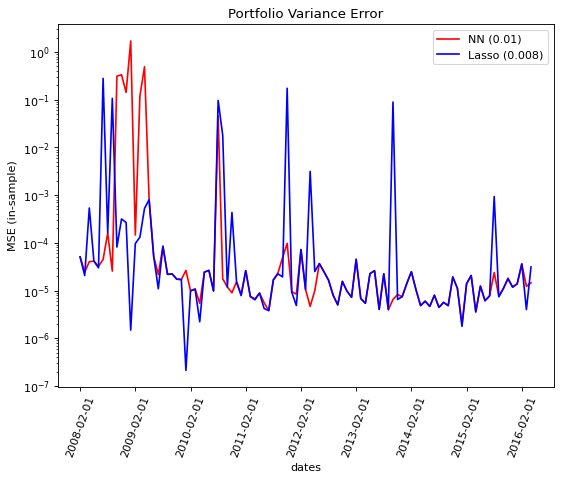

In [128]:
#Portfolio Variance MSE
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
NN_label='NN (' + str(round(MSE_NN,3)) +')'
plt.plot(MSE_array_NN_var_in[:-1], color='red', label=NN_label)
plt.yscale('log')
OLS_label='Lasso (' + str(round(OLS_MSE_var,3)) +')'
plt.plot(MSE_array_OLS_var_in[:-1], color='blue', label=OLS_label)
plt.ylabel('MSE (in-sample)')
plt.xlabel('dates')
plt.title('Portfolio Variance Error')
#plt.xticks(np.arange(0,330,12), dates[np.arange(0,330,12)], rotation=70)
plt.xticks(np.arange(0,100,12), dates[np.arange(0,100,12)], rotation=70)
plt.legend()
plt.savefig('MSE_error.eps', format='eps',dpi=1200,bbox_inches = "tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


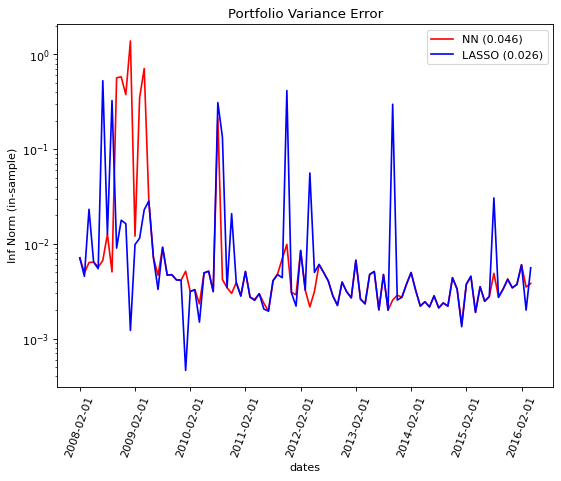

In [129]:
#Variance Inf Norm
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
NN_label='NN (' + str(round(NN_var_inf_norm,3)) +')'
plt.plot(inf_norm_array_NN_var_in[:-1], color='red', label=NN_label)
plt.yscale('log')
OLS_label='LASSO (' + str(round(OLS_var_inf_norm,3)) +')'
plt.plot(inf_norm_array_OLS_var_in[:-1], color='blue', label=OLS_label)
plt.ylabel('Inf Norm (in-sample)')
plt.xlabel('dates')
plt.title('Portfolio Variance Error')
#plt.xticks(np.arange(0,330,12), dates[np.arange(0,330,12)], rotation=70)
plt.xticks(np.arange(0,100,12), dates[np.arange(0,100,12)], rotation=70)
plt.legend()
plt.savefig('MSE_error.eps', format='eps',dpi=1200,bbox_inches = "tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


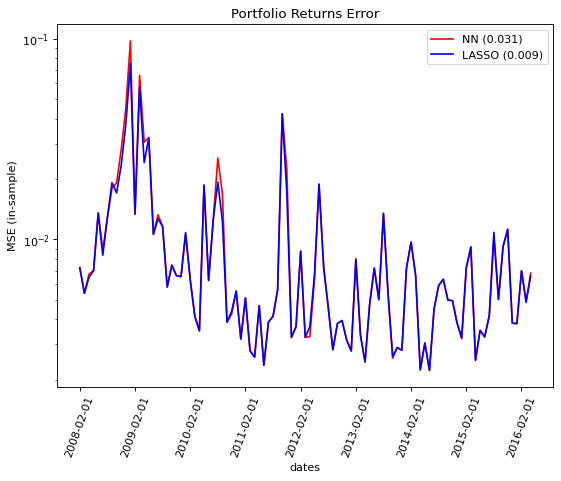

In [130]:
#Portfolio Returns MSE
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
NN_label='NN (' + str(round(NN_MSE_var,3)) +')'
plt.plot(MSE_array_NN_y_in[:-1], color='red', label=NN_label)
plt.yscale('log')
OLS_label='LASSO (' + str(round(MSE_linear,3)) +')'
plt.plot(MSE_array_OLS_y_in[:-1], color='blue', label=OLS_label)
plt.ylabel('MSE (in-sample)')
plt.xlabel('dates')
plt.title('Portfolio Returns Error')
#plt.xticks(np.arange(0,330,12), dates[np.arange(0,330,12)], rotation=70)
plt.xticks(np.arange(0,100,12), dates[np.arange(0,100,12)], rotation=70)
plt.legend()
plt.savefig('MSE_error.eps', format='eps',dpi=1200,bbox_inches = "tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


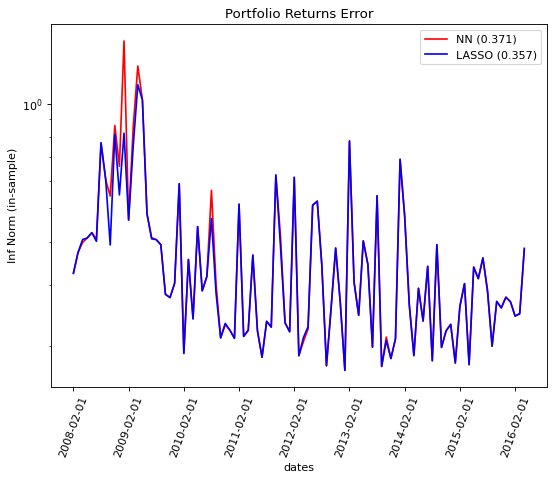

In [131]:
#Portfolio Returns Inf Norm
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
NN_label='NN (' + str(round(NN_y_hat_inf_norm,3)) +')'
plt.plot(inf_norm_array_NN_y_in[:-1], color='red', label=NN_label)
plt.yscale('log')
OLS_label='LASSO (' + str(round(OLS_y_hat_inf_norm,3)) +')'
plt.plot(inf_norm_array_OLS_y_in[:-1], color='blue', label=OLS_label)
plt.ylabel('Inf Norm (in-sample)')
plt.xlabel('dates')
plt.title('Portfolio Returns Error')
#plt.xticks(np.arange(0,330,12), dates[np.arange(0,330,12)], rotation=70)
plt.xticks(np.arange(0,100,12), dates[np.arange(0,100,12)], rotation=70)
plt.legend()
plt.savefig('MSE_error.eps', format='eps',dpi=1200,bbox_inches = "tight")